<a href="https://colab.research.google.com/github/Gorphe/fastai/blob/master/minst_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *

Pixels: the fundations of computer vision

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
(path/'train').ls(
)

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()


In [ ]:
im3_path=threes[1]
im3=Image.open(im3_path)
im3

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
import pandas as pd
im3_t = tensor(im3)
df=pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font_size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Firest try: pixel similarity

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

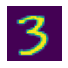

In [ ]:
show_image(three_tensors[1])

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
stacked_threes.ndim

3

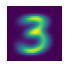

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

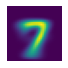

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [ ]:
a_3 = stacked_threes[1]
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:

dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [ ]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Computing metrics using broadcasting

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
def mnist_distance(a,b): 
  dist= (a-b).abs().mean((-1,-2))
  return dist

mnist_distance(a_3,mean3)

tensor(0.1114)

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist

tensor([0.1241, 0.1360, 0.1254,  ..., 0.1381, 0.1325, 0.1419])

In [ ]:
def is_3(x) :
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1-is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Stoachastic gradient descent

In [ ]:
def f(x):
  return x**2

In [ ]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

In [ ]:
xt = tensor(3.).requires_grad_()

In [ ]:
yt=f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
yt.backward()

In [ ]:
xt.grad

tensor(6.)

In [ ]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [ ]:
def f(x):
  return (x**2).sum()

In [ ]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The MNIST loss function

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)


In [ ]:
train_y = tensor([1]*len(threes) +[0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3_tens)+[0]*len(valid_7_tens)).unsqueeze(1)
valid_dset=list(zip(valid_x, valid_y))


In [ ]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
bias

tensor([-1.6853], requires_grad=True)

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([9.3312], grad_fn=<AddBackward0>)

In [ ]:
def linear1(xb):
  return xb@weights + bias

preds= linear1(train_x)


In [ ]:
corrects= (preds>0.0).float()==train_y
corrects.float().mean().item()

0.6048725247383118

In [ ]:
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 6, 14,  5,  1,  9]),
 tensor([11,  2,  8,  3, 10]),
 tensor([12,  4,  7, 13,  0])]

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

Putting it all together

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
preds = linear1(batch)
preds

tensor([[ 9.3312],
        [10.9280],
        [ 4.7978],
        [ 7.3385]], grad_fn=<AddBackward0>)

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(-7.0989, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.1511), tensor([-1.]))

In [ ]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.3022), tensor([-2.]))

In [ ]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [ ]:
def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()


In [ ]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5)==yb
  return correct.float().mean()


In [ ]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(),4)


In [ ]:
lr=1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9537

In [ ]:
for i in range(100):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 

Creating an optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)


In [ ]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [ ]:
class BasicOptim :
  def __init__(self, params, lr): 
    self.params,self.lr=list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None
 

In [ ]:
opt=BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()
    

In [ ]:
validate_epoch(linear_model)

0.4845

In [ ]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 

In [ ]:
linear_model = nn.Linear(28*28,1)
opt= SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 0.9533 

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func= SGD, loss_func = mnist_loss, metrics= batch_accuracy)

In [ ]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,-82.939682,-335.748169,0.953386,00:00
1,-309.312866,-672.065002,0.953386,00:00
2,-570.700806,-1008.381897,0.953386,00:00
3,-854.954163,-1344.698608,0.953386,00:00
4,-1152.384277,-1681.015503,0.953386,00:00
5,-1456.717896,-2017.332520,0.953386,00:00
6,-1764.422241,-2353.649414,0.953386,00:00
7,-2073.690918,-2689.966064,0.953386,00:00
8,-2383.658936,-3026.282959,0.953386,00:00
9,-2693.931396,-3362.600098,0.953386,00:00


Adding a non linearity

In [ ]:
def simple_net(xb):
  res = xb@w1 +b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,114418144.000000,-1551916800.000000,0.962218,00:00
1,1490207416665505792.000000,-27483718103330717696.000000,0.962218,00:00
2,24079866156465436605609410560.000000,-487680826748268860905118236672.000000,0.961727,00:00
3,nan,nan,0.962218,00:00
4,nan,nan,0.504416,00:00
5,nan,nan,0.504416,00:00
6,nan,nan,0.504416,00:00
7,nan,nan,0.504416,00:00
8,nan,nan,0.504416,00:00
9,nan,nan,0.504416,00:00


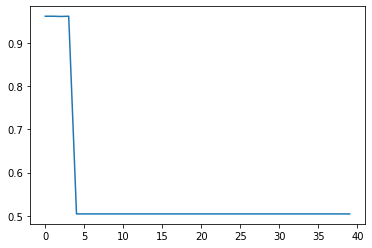

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [ ]:
learn.recorder.values[-1][2]

0.5044161081314087

Going deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn=cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1,0.1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.072127,0.029334,0.992149,02:45
